In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate

from tqdm import tqdm  # progress bar

ChopTFs:
- AD tile pre = "GGCTAGC", post = "TGACTAG"
    - length = 120
- AD BC pre = "CGCGCC", post = "GGGCCC"
    - length = 11
- RPTR BC pre = "CTCGAG", post = "GGCCGC"
    - length = 14
 
Data:
- Step 1: /global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2024/A10_A11/results/A11_S2.fastq.gz.assembled.fastq
- Step 2: /global/scratch/projects/fc_mvslab/data/sequencing/czb_new_sept2025/MAZ10/ChopTF/results

# Step 1 - with Pre & Post sequences

In [3]:
EC_AD = finder.Barcode(name = "AD",
                       preceder = "GGCTAGC",
                       post = "TGACTAG",
                       length = 120)

EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "GGGCCC",
                       length = 11)

EC_RPTR_BC = finder.Barcode(name = "RPTR_BC",
                       preceder = "CTCGAG",
                       post = "GGCCGC",
                       length = 14)


In [5]:
# step1_mapper = initial_map.InitialMapper(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs_redone.db",
#                                        step_name = "step1", #Should include time point, replicate (don't need to specify BC type(s))
#                                        seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2024/A10_A11/results/A11_S2.fastq.gz.assembled.fastq",
#                                        design_file_path =  "/global/scratch/projects/fc_mvslab/OpenProjects/Marissa/DesignFiles/ChopTFDesign.csv",
#                                        bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
#                                        reverse_complement = True)

In [6]:
# step1_mapper.preview_map()

In [8]:
# refiner_pre_post = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs_redone.db",
#                                 bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
#                                 column_pairs = [("RPTR_BC", "AD")],
#                                 design_check = True, 
#                                  reads_threshold = 10,
#                                 map_order = ['quality_designed', 'grouped', 'thresholded', 'unique_target'],
#                                 step_name = "step1",
#                                 should_check_exists = True,
#                                 plot_histograms = False)
# refiner_pre_post.refine_map_from_db()

In [9]:
# refiner.save_loss_table()
# refiner.plot_loss(text_offset = -0.15)

# Pre and post check

In [15]:
SK_order_refiner_pre_post = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs_redone.db",
                                bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                                column_pairs = [("RPTR_BC", "AD")],
                                design_check = True, 
                                 reads_threshold = 10,
                                          descriptor = "SK_order",
                                map_order = ['grouped', 'thresholded', 'barcode_exists', 'unique_target', 'quality_designed'],
                                step_name = "step1",
                                should_check_exists = True,
                                plot_histograms = True)

Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_SK_order_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. unique_target
6. quality_designed



Grouping step1_AD_AD_BC_RPTR_BC_initial...
Skipping — table step1_AD_AD_BC_RPTR_BC_initial_grouped already exists and is initial/grouped.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

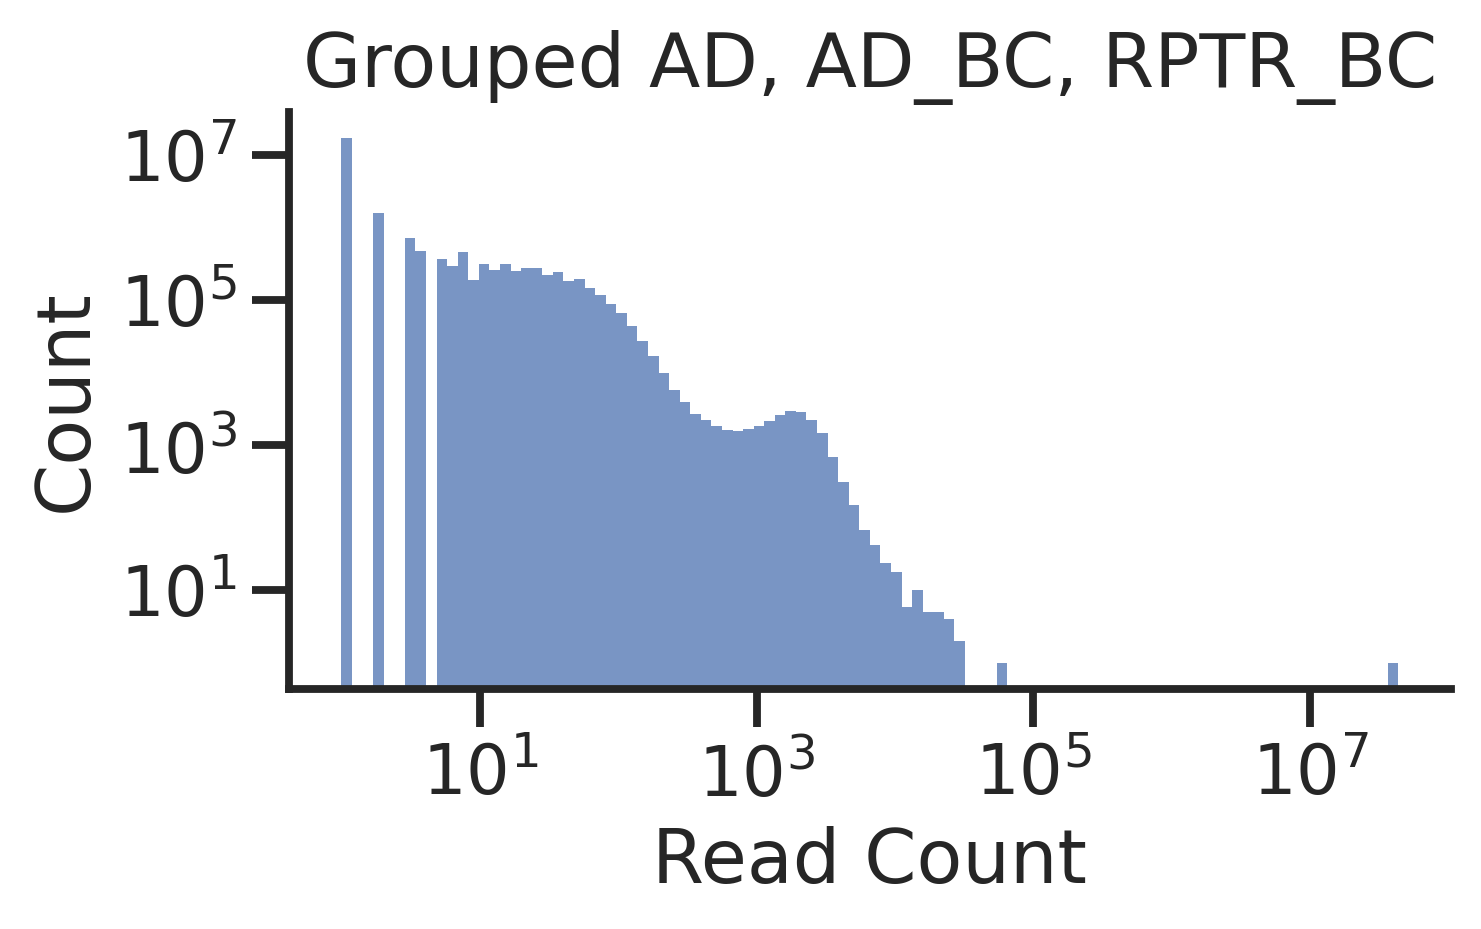

Done in 46.25 seconds.

Thresholding...
Using reads threshold of 10.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

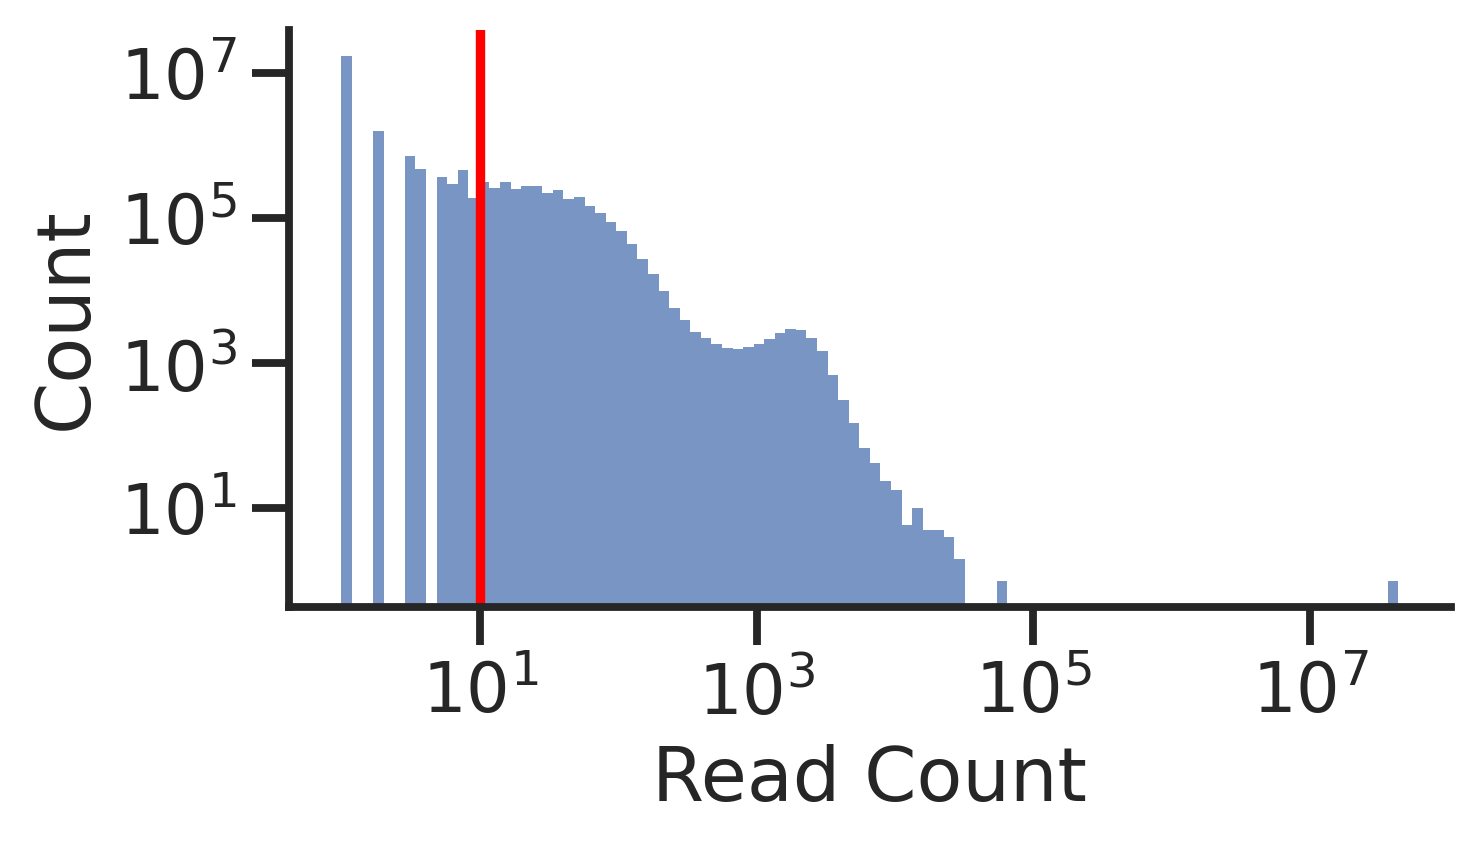

Done in 19.40 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 1.45 seconds.

Filtering keys to keep only those mapping to a single target...
	Checking each RPTR_BC only maps to one AD.
Done in 1.44 seconds.

Filtering to quality and designed...
Done in 0.44 seconds.

Done.


In [16]:
SK_order_refiner_pre_post.refine_map_from_db()

In [31]:
thresholded = SK_order_refiner_pre_post.get_map_df('thresholded')

# Removes reads with poor quality
thresholded

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed
0,,,,43388901,False,False,False,0
1,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,,,59042,True,False,False,1
2,TTCTCATTTGCTCAAAGAGCTAAGATTGAAATTATTAGAATCTTGT...,,,29087,True,False,False,1
3,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...,,,28025,True,False,False,1
4,TATACTCCAGAAAGAGGTTCTGCTAATAGAGCTAGATCTCCATTGC...,,,26595,True,False,False,1
...,...,...,...,...,...,...,...,...
2951411,,ACCCAGCACGG,CCCATTCCAGTCCT,11,False,True,True,0
2951412,,CACCCACTCCT,,11,False,True,False,0
2951413,TCTCCACAAGGTTCTGATTTGGCTTCTAATTCTGCTACTCAATATA...,,ATCAGGATTAAATC,11,True,False,True,1
2951414,TTCTCTTCTATGCATACTACTGCTACATTTCAAATTAAACAAGAAG...,,TCTGCAAATACGTT,11,False,False,True,0


In [34]:
thresholded["AD_qual"].value_counts()

AD_qual
False    1834542
True     1116874
Name: count, dtype: int64

In [35]:
thresholded["AD_BC_qual"].value_counts()

AD_BC_qual
False    1865206
True     1086210
Name: count, dtype: int64

In [36]:
thresholded["RPTR_BC_qual"].value_counts()

RPTR_BC_qual
True     2317360
False     634056
Name: count, dtype: int64

In [33]:
thresholded[thresholded["AD_qual"] & thresholded["AD_BC_qual"] & thresholded["RPTR_BC_qual"]]

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed
971,CAAGCTACTTTGACTTCTTTGCAAACTACTTTGAAGAATTTGAAAG...,TTCCGCGGTCC,AGGAAGATGCCGCC,3533,True,True,True,1
2102,CCACCATGTGCTAGATGTAAGAGAGAATTGAAGAAATGTATCTTCT...,GCCGTCCCATC,TCGCCCAGGCACTA,2938,True,True,True,1
3330,TTTGTTGGTGTTGTTAGAAATATTACTGATCATACTGCTAATATCT...,TTTCTGGTCGT,CATTCATTCGTTTT,2612,True,True,True,1
4459,TTCTCTGATAGAGTCTTGTGGTTGAAAGCTGAAAGAATCTTGAGAA...,GTACAGACCTT,TCGTATCTATTCTG,2395,True,True,True,1
5524,CCACCAACTGATGTTTCTTTGGGTGATGAATTGCATTTGGATGGTG...,GTGAGAATGGA,ATAATTGGACTCTC,2230,True,True,True,1
...,...,...,...,...,...,...,...,...
2951357,ACTTATGTTCCAGTTAGATTGGCTAAATATCCAACTGGTCCATCTT...,CACACCGGGCC,AGGAGGCCGTTTAA,11,True,True,True,1
2951367,ATTAGAGATACTGCTGTTACTTTGAAAGAAGCTACTCCAGATGAAT...,AGAGCGAGGGG,AGGCTCGTAATCGT,11,True,True,True,1
2951372,TATAGACCATTTATTCATTATTTGTCTAGAAATATGAATGCTGAGA...,ACATATTGCCA,TTAGGGGAGGCTTA,11,True,True,True,1
2951391,GATCAAACTTCTTCTATTAAACCTAAGAAGAAGAGATGTGTTTCTA...,TGCATCTTCTC,TTAAATAAACTTTG,11,True,True,True,1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_SK_order_loss_summary'
Done in 3.12 seconds.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_SK_order_loss_summary'
Done in 3.00 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

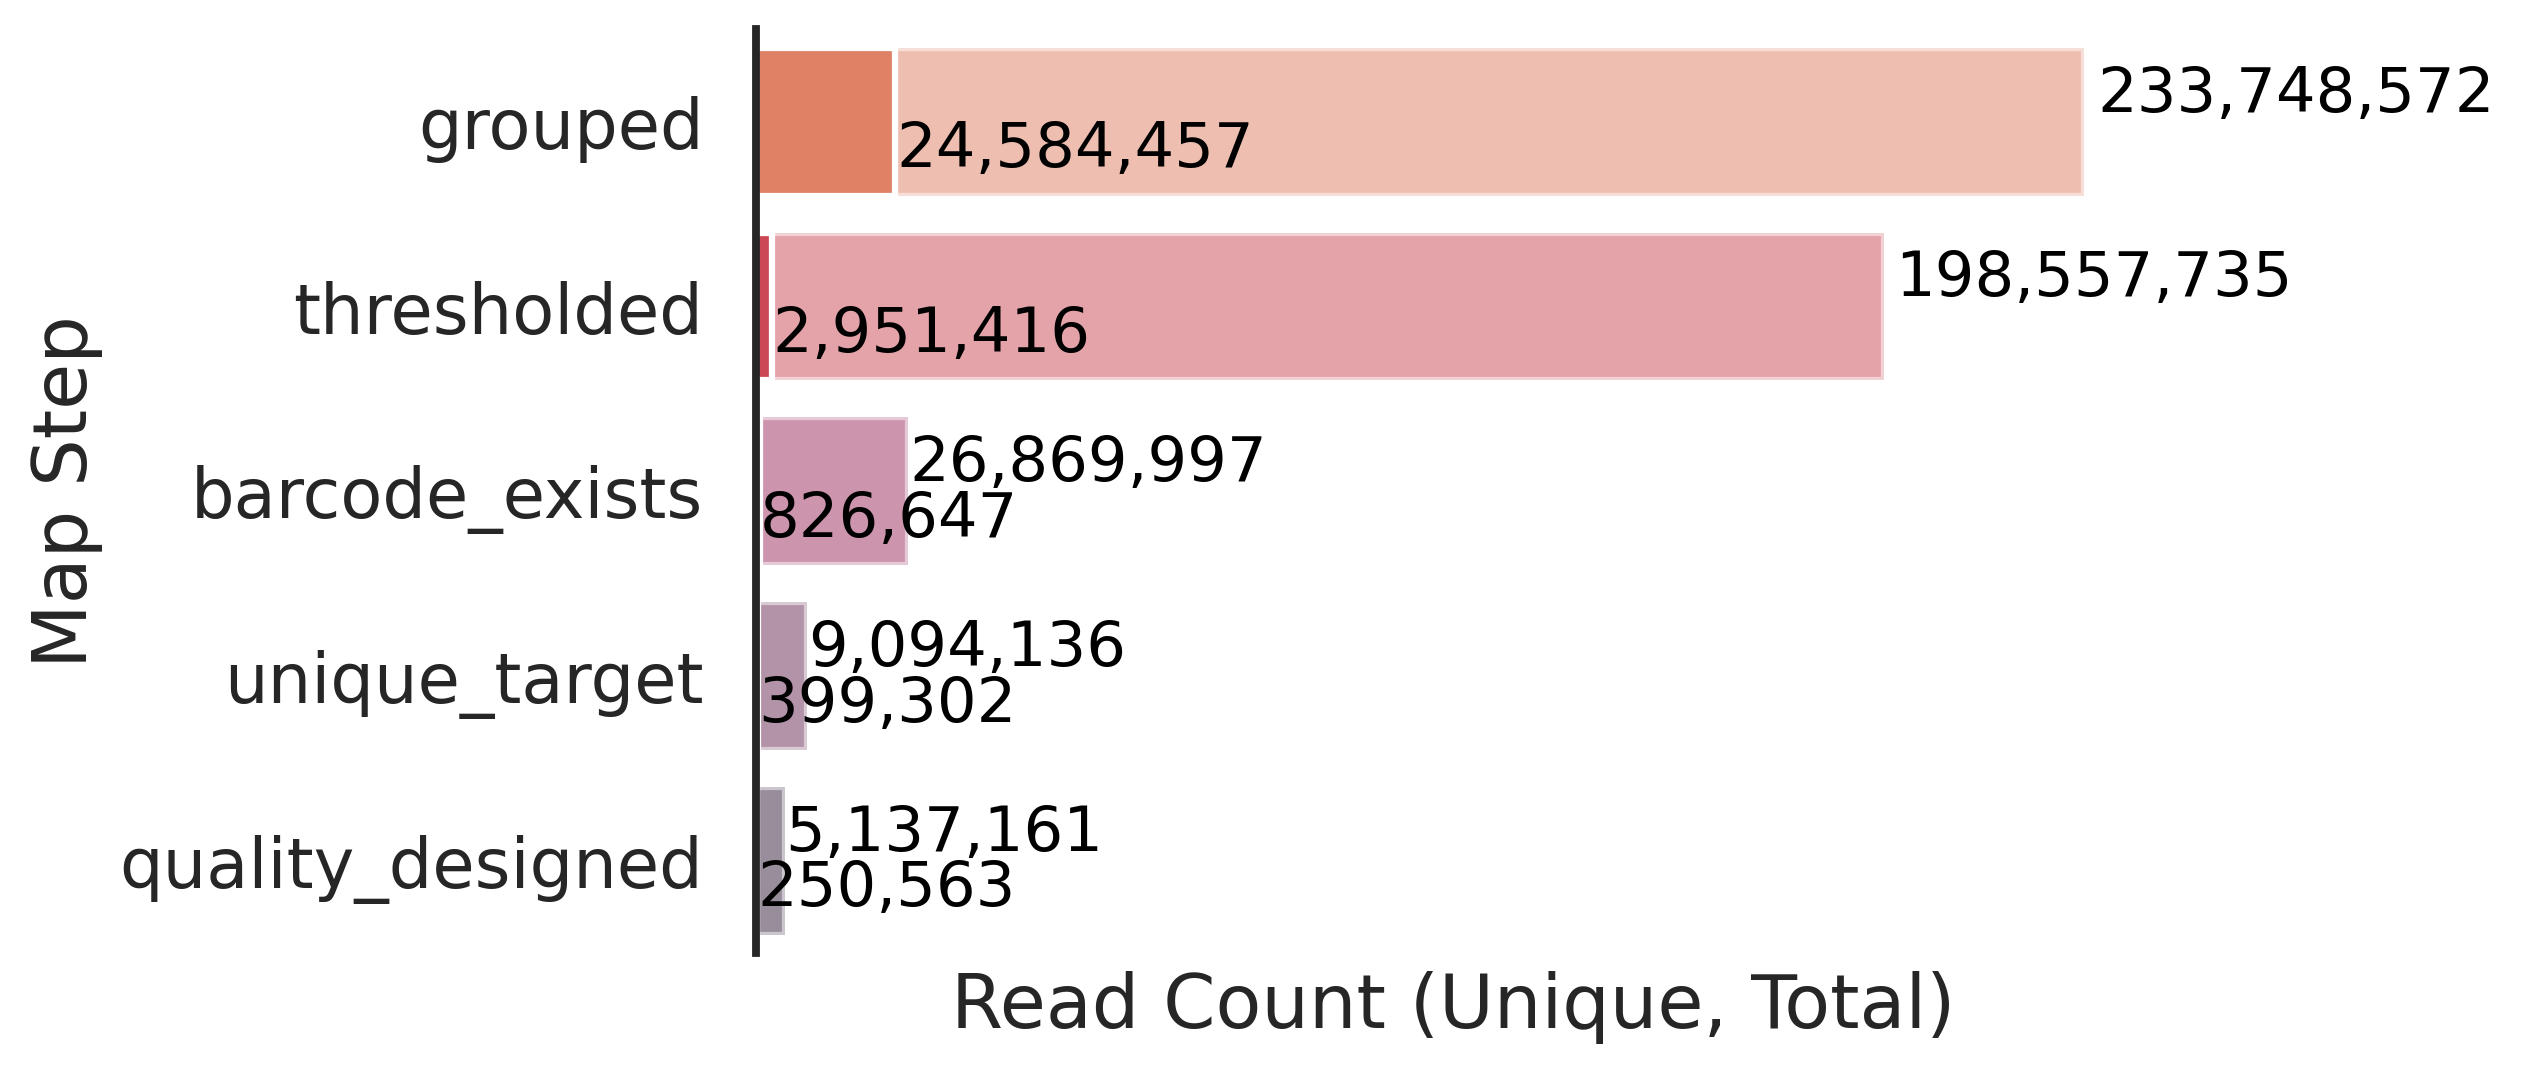

In [17]:
SK_order_refiner_pre_post.save_loss_table()
SK_order_refiner_pre_post.plot_loss(text_offset = -0.15)

In [19]:
# 10% of reads at unique_target have no AD
SK_order_refiner_pre_post.get_map_df('unique_target')["AD"].value_counts() / len(SK_order_refiner_pre_post.get_map_df('unique_target')["AD"].value_counts() )

AD
                                                                                                                            0.099803
TATGCTATTCCAGAGAATGAATTGTTGGATGAAGATACTATGAACTTTATTTCTTCTTTGAAGAATGATTTGTCTAATATTTCTAATTCTTTGCCATTTGAATATCCACATGAAATTGCT    0.000583
TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACTTTGATACATTTGATATTTCTCCAAACTTTGGTCATTCTGATTTGGAGAATCCAGATACTTGGTTCTCTTTGTTT    0.000535
TCTACTATTCCATTGGATGCTATGCCAAGAGATGCTTTGCATGGTGCTGATGCTTCTGAAGAAGATGATATGTCTGATGGTTTGCCAGCTTTGAAGACTGATCCAAATAATAATGGTGCT    0.000507
TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATAATTCTAAAGAAGCTACTTCTGCTGCTGATAATGATATTCCAGTTACTACTGATGATGTTTCTTTGGCTGATAAA    0.000452
                                                                                                                              ...   
CAACAATTGATTGAGAATGCTATTGAATCTGGTGTTGTTGATTTGGAAACTTTGATTTGCCACCATTCTTGTCTTTGGATGGTTTGCCACCAGCTTCTTCTTCTGCTGCTGTTGCTGCT     0.000007
GCTAATCAGAAAATAATCAAAGAGTTGAGAATACTAGAGTCTTGATGGGTCCAGCTGTTCCAGCTA

# Pre check only

In [20]:
SK_order_refiner_pre_only = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs_redone_no_post.db",
                                bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                                column_pairs = [("RPTR_BC", "AD")],
                                design_check = True, 
                                 reads_threshold = 10,
                                          descriptor = "SK_order",
                                map_order = ['grouped', 'thresholded', 'barcode_exists', 'unique_target', 'quality_designed'],
                                step_name = "step1",
                                should_check_exists = True,
                                plot_histograms = True)

Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_SK_order_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. unique_target
6. quality_designed



Grouping step1_AD_AD_BC_RPTR_BC_initial...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

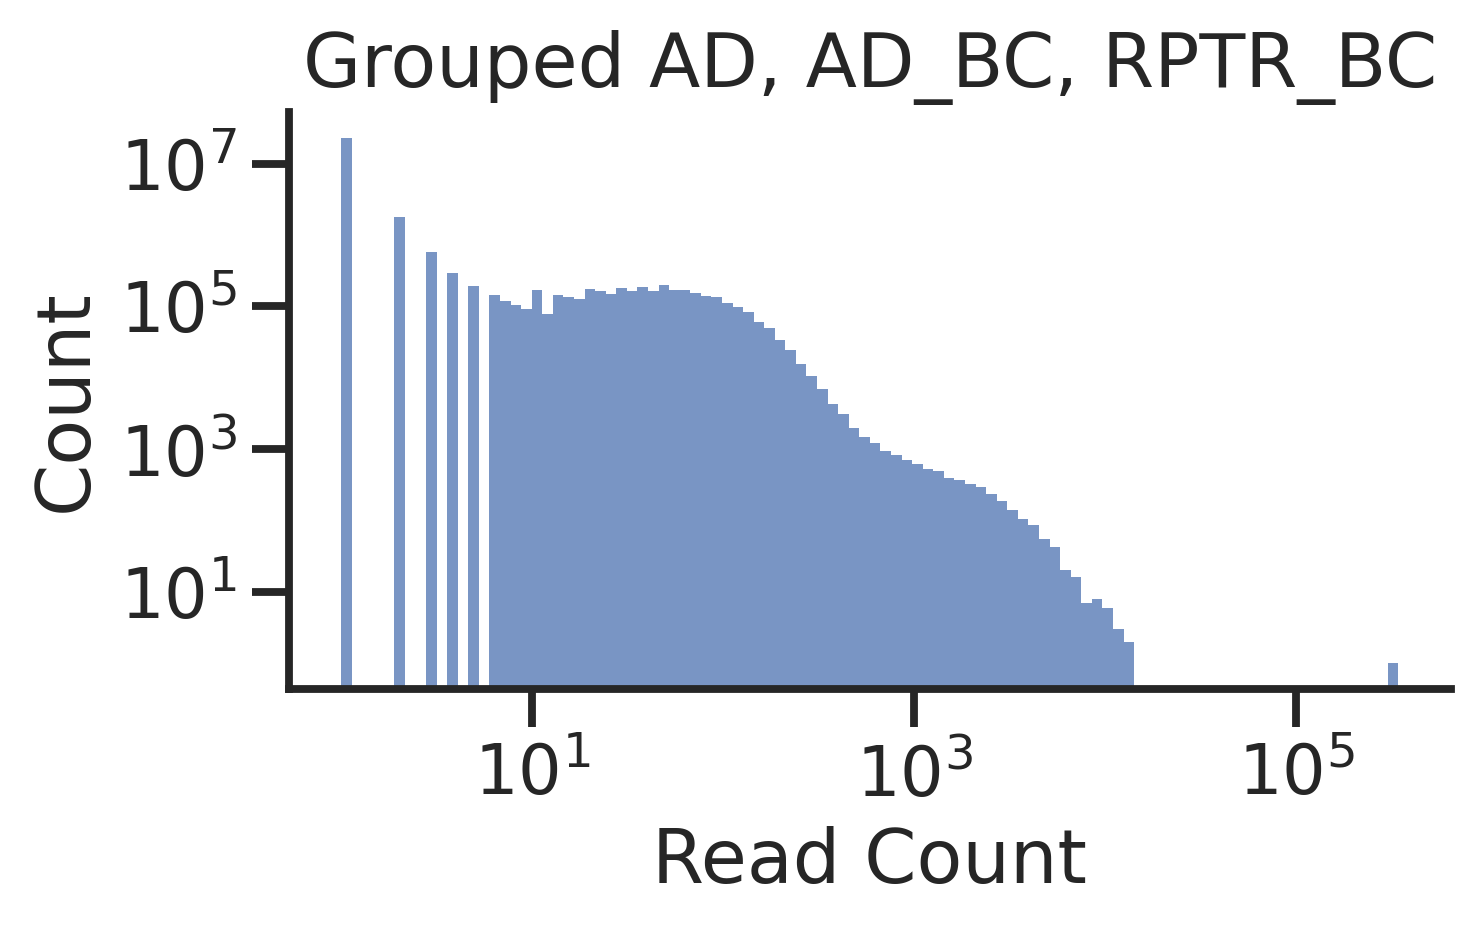

Done in 57.15 seconds.

Thresholding...
Using reads threshold of 10.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

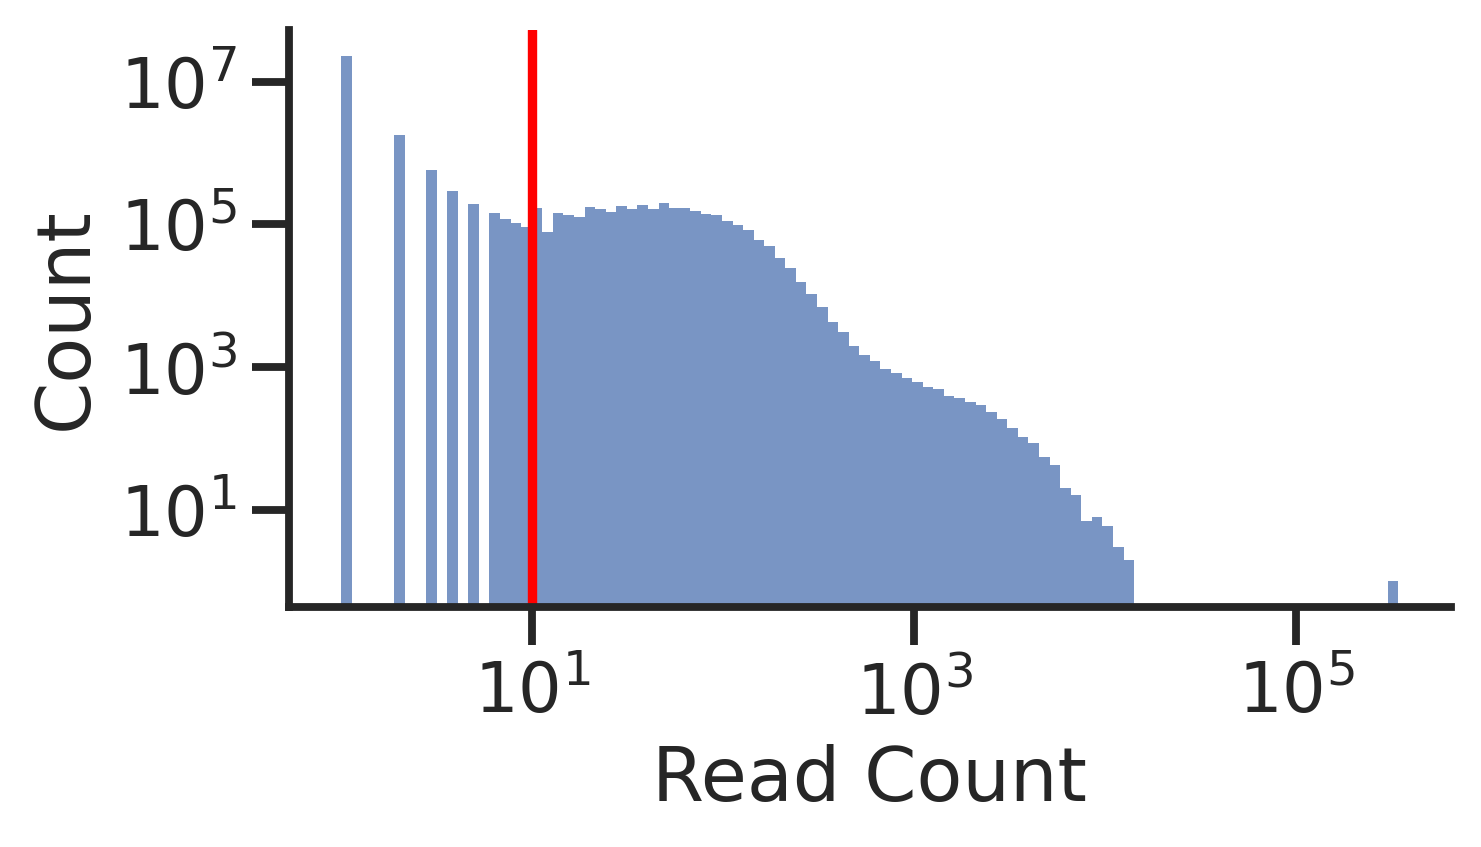

Done in 26.55 seconds.

Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.21 seconds.

Filtering keys to keep only those mapping to a single target...
	Checking each RPTR_BC only maps to one AD.
Done in 0.83 seconds.

Filtering to quality and designed...
Done in 0.24 seconds.

Done.


In [22]:
SK_order_refiner_pre_only.refine_map_from_db()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_SK_order_loss_summary'
Done in 3.57 seconds.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_SK_order_loss_summary'
Done in 3.17 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

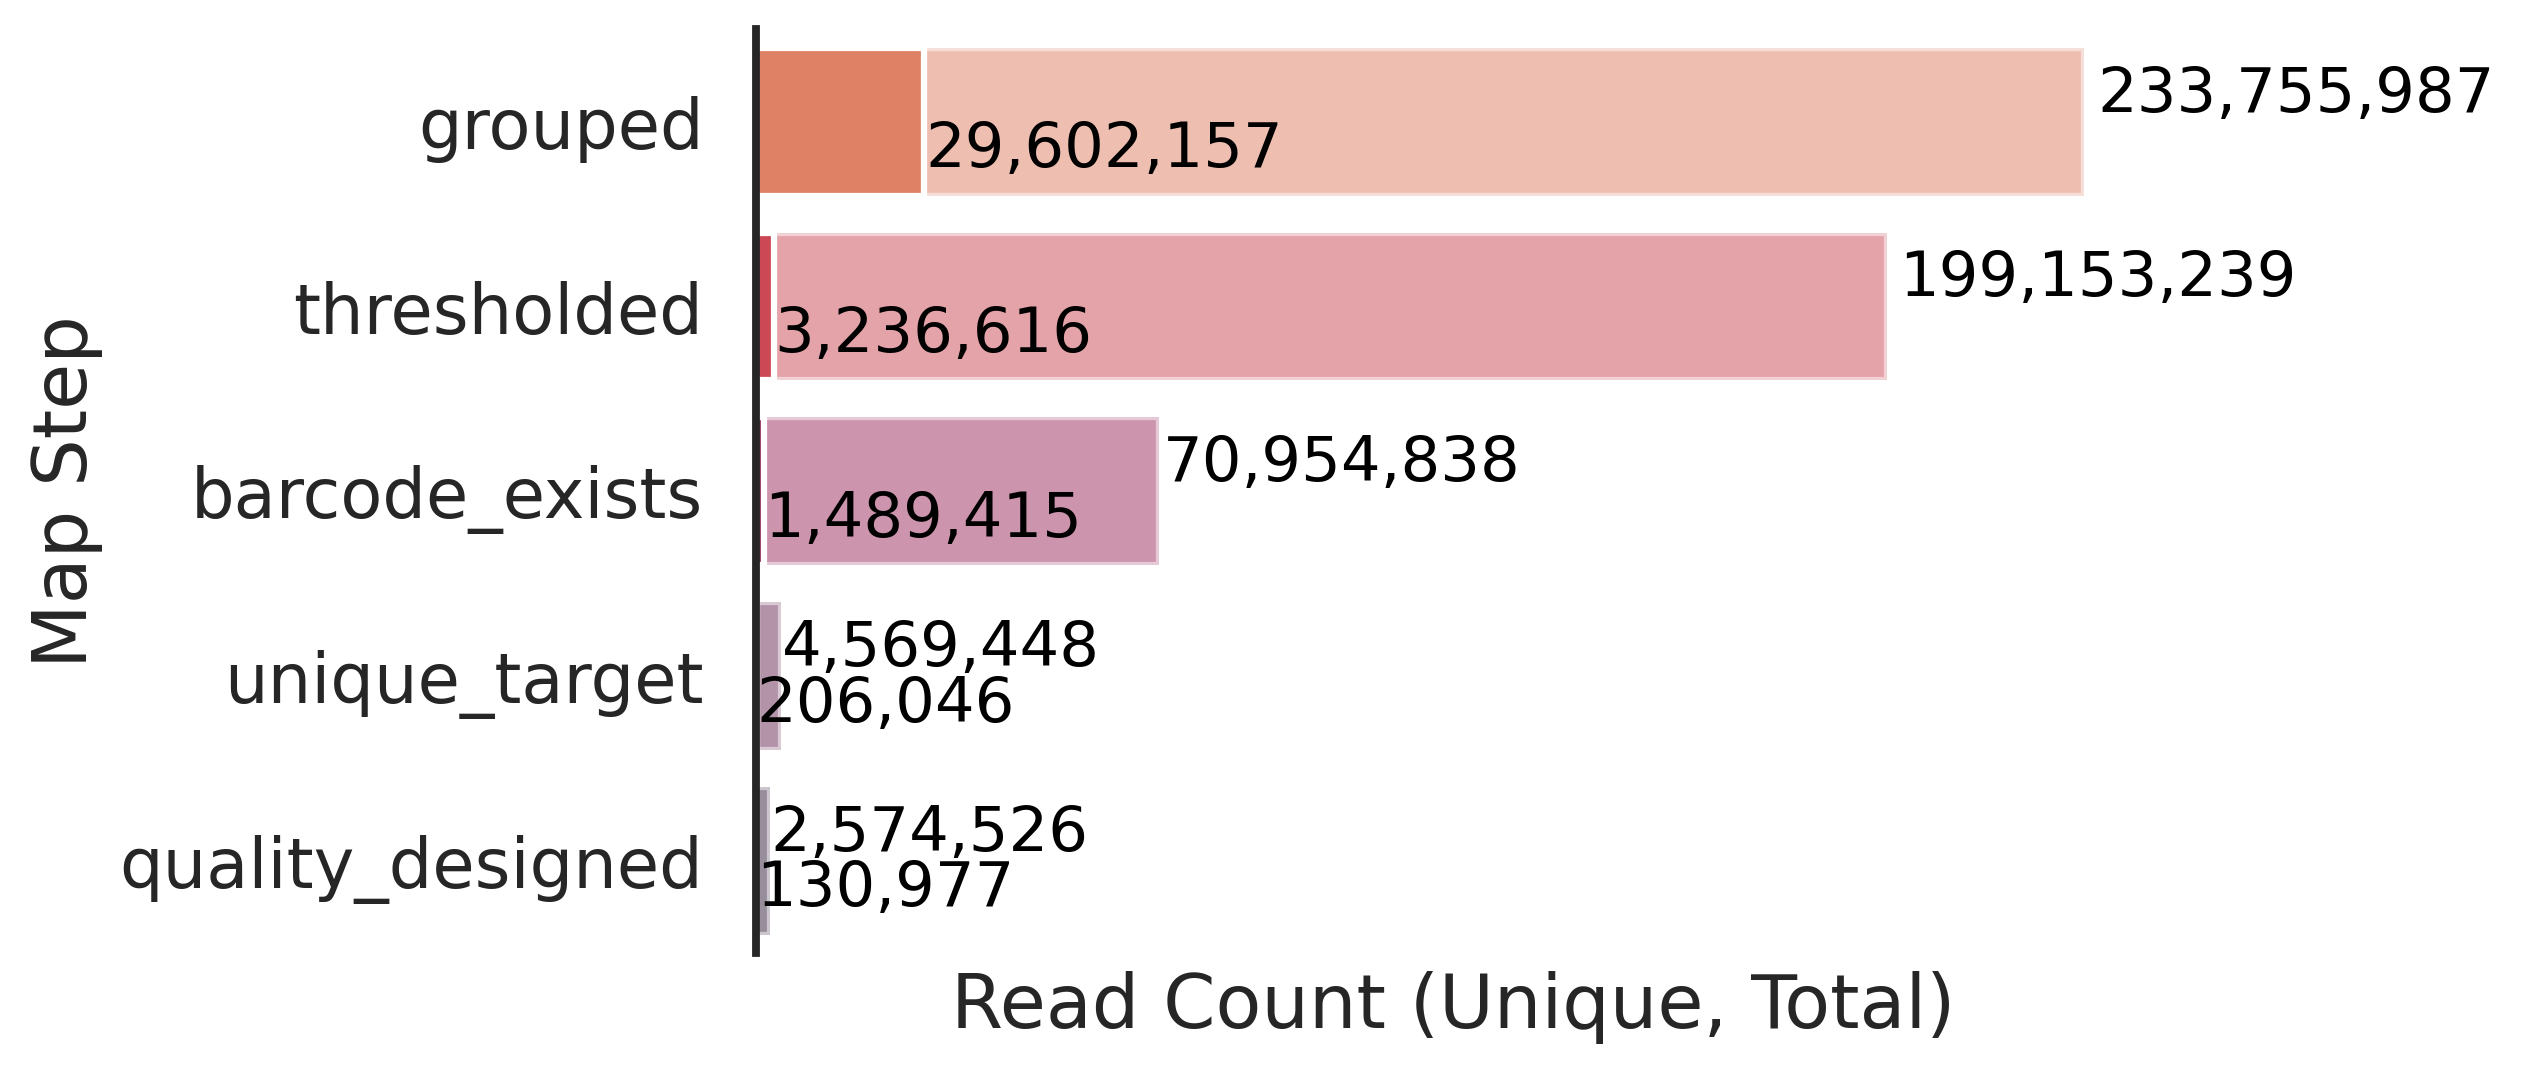

In [23]:
SK_order_refiner_pre_only.save_loss_table()
SK_order_refiner_pre_only.plot_loss(text_offset = -0.15)

In [24]:
# 10% of reads at unique_target have no AD
SK_order_refiner_pre_only.get_map_df('unique_target')["AD"].value_counts() / len(SK_order_refiner_pre_only.get_map_df('unique_target')["AD"].value_counts() )

AD
                                                                                                                            0.095914
TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACTTTGATACATTTGATATTTCTCCAAACTTTGGTCATTCTGATTTGGAGAATCCAGATACTTGGTTCTCTTTGTTT    0.000606
TATGCTATTCCAGAGAATGAATTGTTGGATGAAGATACTATGAACTTTATTTCTTCTTTGAAGAATGATTTGTCTAATATTTCTAATTCTTTGCCATTTGAATATCCACATGAAATTGCT    0.000559
TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATAATTCTAAAGAATGGACTTCTTTGTTTGATAATGATATTCCAGTTACTACTGATGATGTTTCTTTGGCTGATAAA    0.000475
TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATAATTCTAAAGAAGCTACTTCTGCTGCTGATAATGATATTCCAGTTACTACTGATGATGTTTCTTTGGCTGATAAA    0.000440
                                                                                                                              ...   
TCATTTACTTCTAGAAGATCTTCTAGATCTAGATCTATTTCTCCAGATGAGAAAGCTAAATCTATTTCTGCTAATAGAGGAAATTGTTGGAAATGGCTGATTTGTTGCCATCTTCTGAAT    0.000012
AGAATCTTGGAATCTTGTTTTGCTAAGAATATTGAGAATCCATATTTGGATACTAAAGGTTTGGAG

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_SK_order_loss_summary'
Done in 2.72 seconds.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_SK_order_loss_summary'
Done in 3.34 seconds.



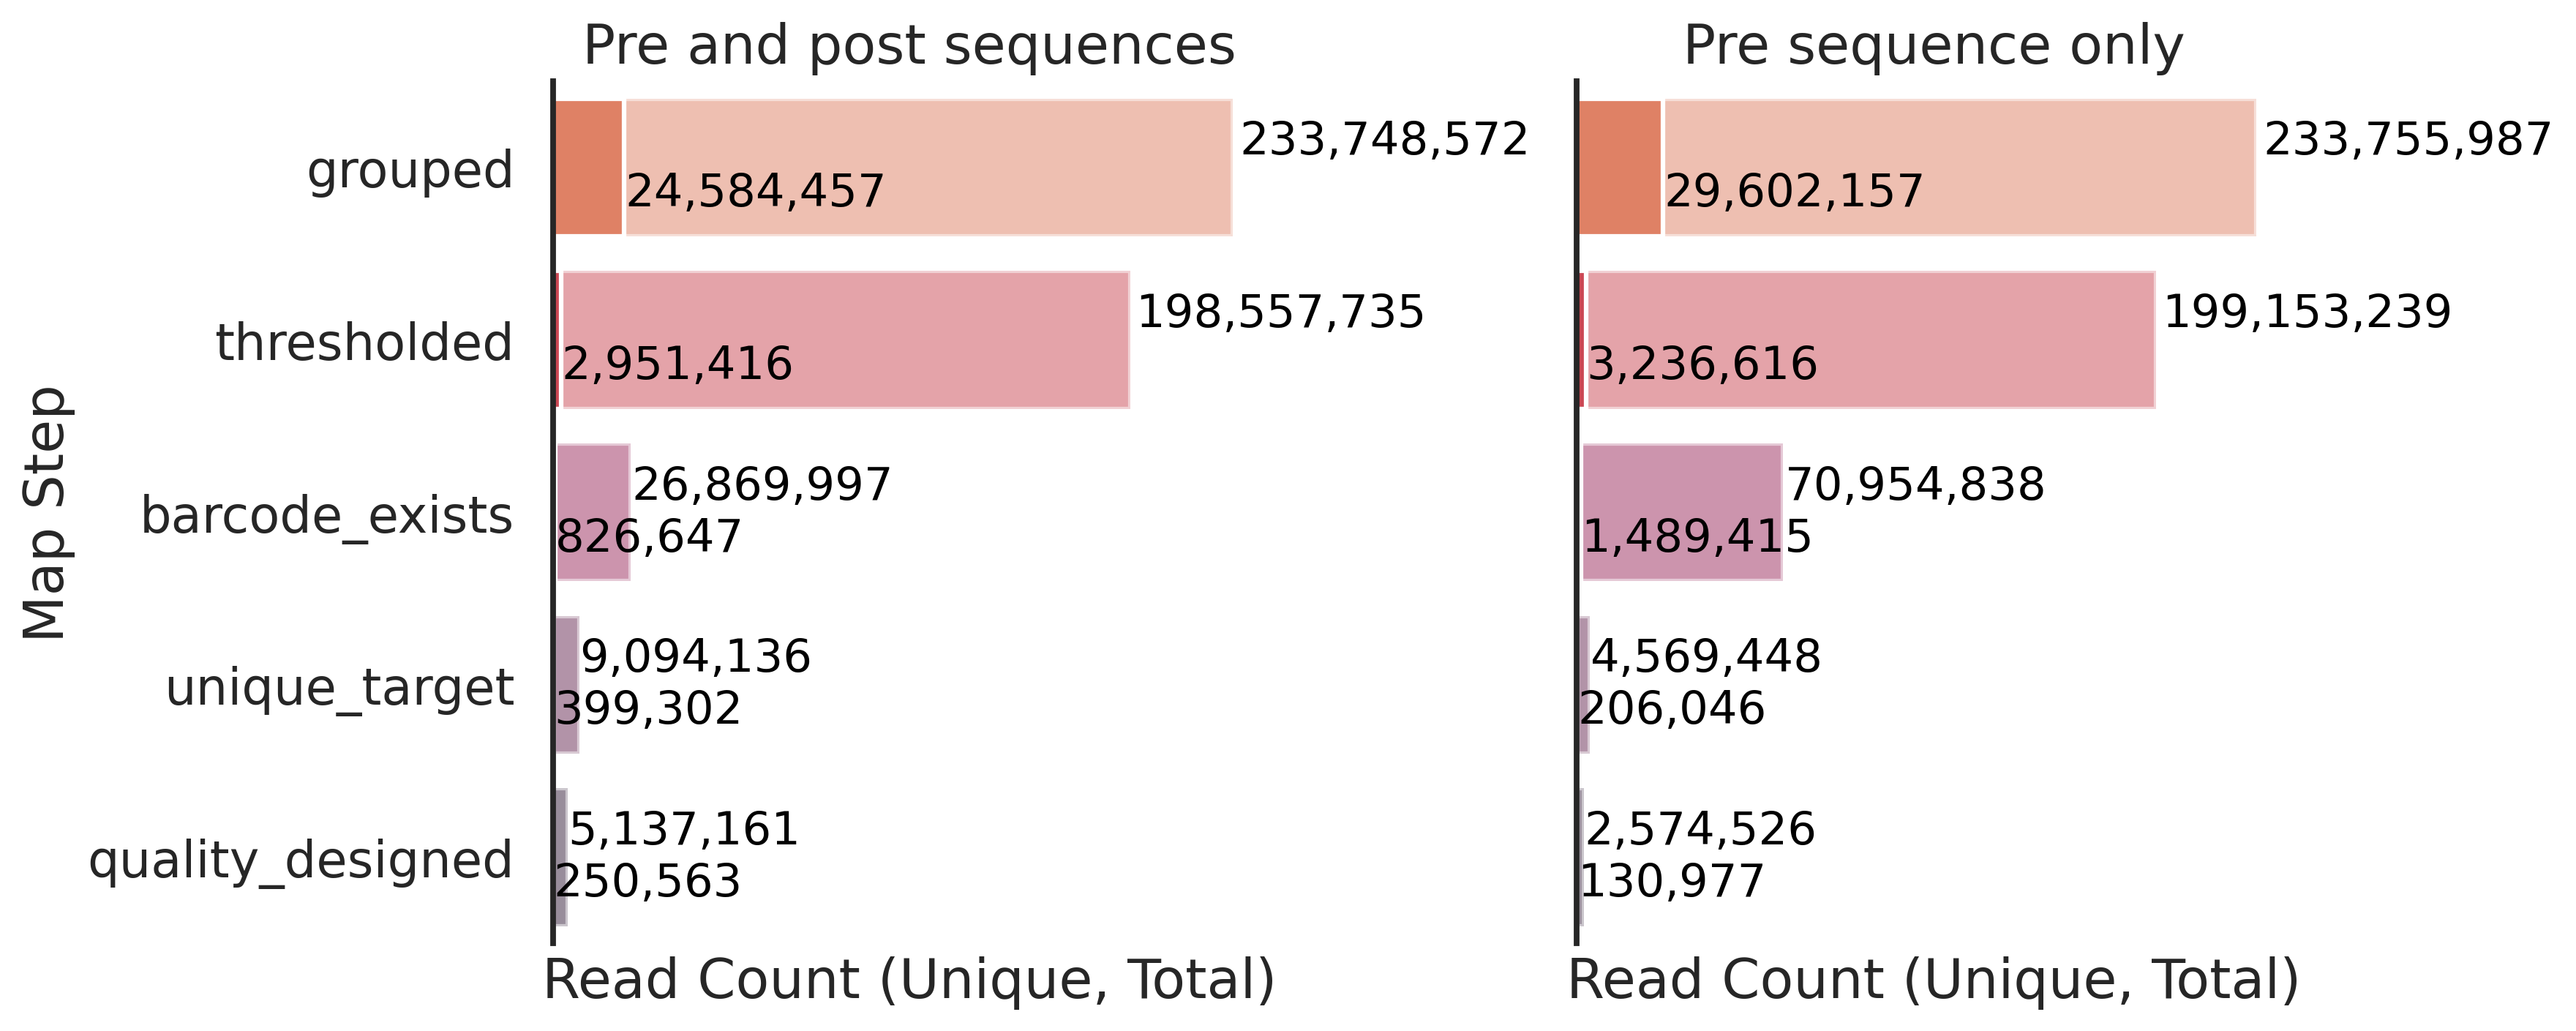

In [27]:
fig, axs = plt.subplots(1, 2, figsize = (12,5), dpi = 300, sharey = True, sharex = True)

SK_order_refiner_pre_post.plot_loss(text_offset = -0.15, ax = axs[0])
axs[0].set_title("Pre and post sequences")

SK_order_refiner_pre_only.plot_loss(text_offset = -0.15, ax = axs[1])
axs[1].set_title("Pre sequence only")
axs[1].set_ylabel("")

fig.tight_layout(pad = 1)